In [1]:
import os
import json
from pathlib import Path
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt


from data import get_dataset, get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels, parse_image_function
from train import SiameseModel


import tensorflow as tf

from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [2]:
with open('hyperparameters/initial_run.json', 'rb') as f:
    params = json.load(f)

In [11]:
params['batch_size']['train'] = 32
params['batch_size']['val'] = 512

In [4]:
data_dir = '/Users/deepakduggirala/Documents/ELPephant-cropped'

In [5]:
cache_files = {
        'train': str(Path(data_dir) / 'train.cache'),
        'val': str(Path(data_dir) / 'val.cache')
    }

In [12]:
train_ds, N_train = get_dataset(get_ELEP_images_and_labels, params, data_dir, 'val', 
                                augment=True,
                                cache_files=cache_files, 
                                model_preprocess=False, 
                                shuffle=True)
# train_ds_aug, N_train = get_dataset(get_ELEP_images_and_labels, params, data_dir, 'val', 
#                                 augment=True,
#                                 cache_files=None, 
#                                 model_preprocess=False, 
#                                 shuffle=False)

In [23]:
images, labels = next(train_ds.as_numpy_iterator())
# images_aug, labels = next(train_ds_aug.as_numpy_iterator())

In [9]:
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [ ]:
from collections import Counter

Counter(labels)

In [54]:
lab_idx = (labels == b'866') | (labels==b'2036')
img_fil = images[lab_idx]
lab_fil = labels[lab_idx]

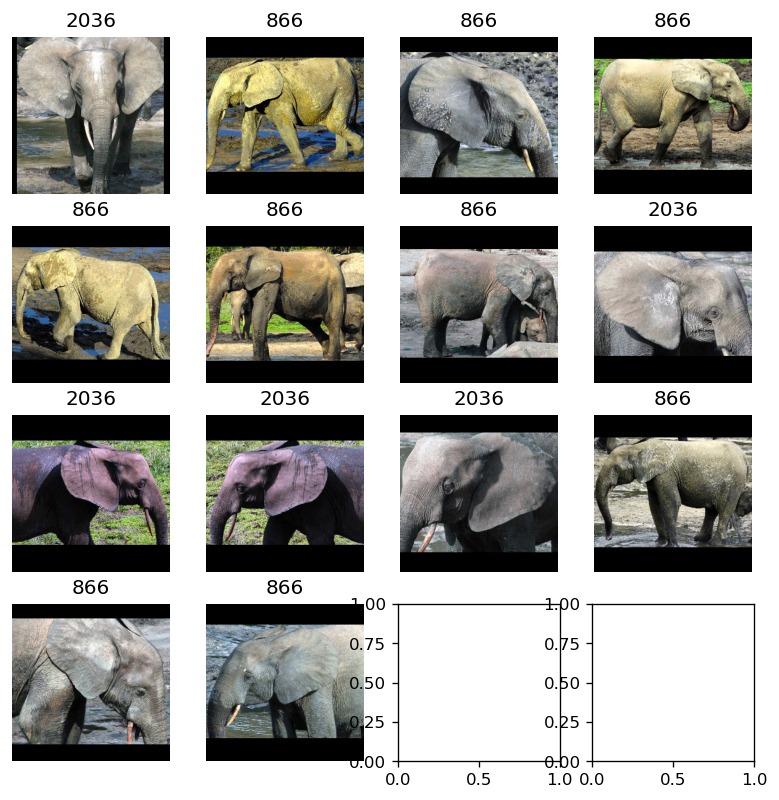

In [56]:
R=4
C=4
fig, axes = plt.subplots(nrows=R, ncols=C, figsize=(8,8), dpi=120)
l,r=0,0
for k in range(14):
    i = k//C
    j = k%C
    ax = axes[i,j]
    ax.imshow(normalize(img_fil[k]))
    ax.set_title(lab_fil[k].decode("utf-8"))
    ax.axis('off')

In [41]:
lab_idx = labels == b'866'
img_fil = images[lab_idx]
lab_fil = labels[lab_idx]

In [28]:
img_fil.shape

(9, 256, 256, 3)

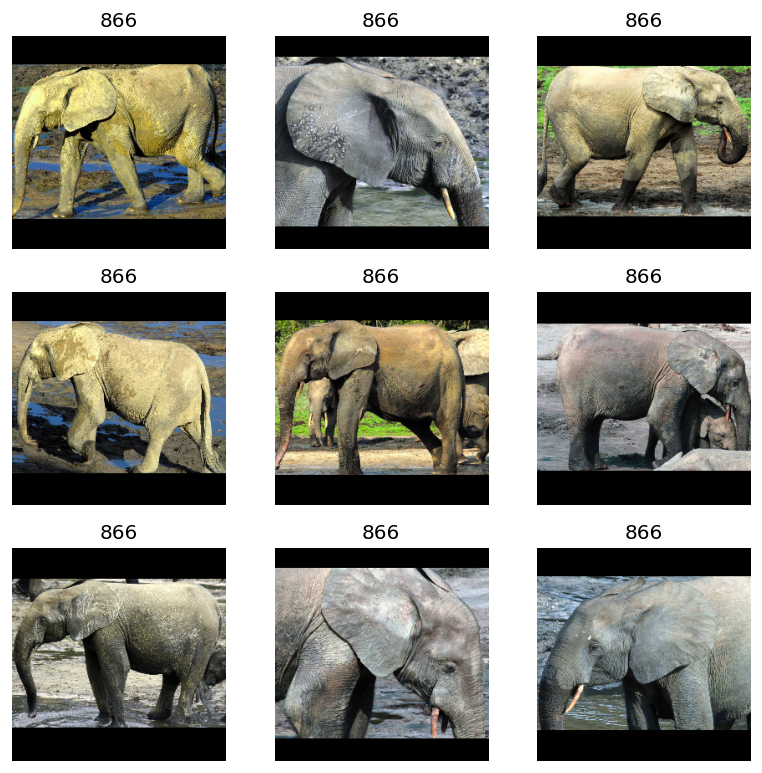

In [42]:
R=3
C=3
fig, axes = plt.subplots(nrows=R, ncols=C, figsize=(8,8), dpi=120)
l,r=0,0
for k in range(9):
    i = k//C
    j = k%C
    ax = axes[i,j]
    ax.imshow(normalize(img_fil[k]))
    ax.set_title(lab_fil[k].decode("utf-8"))
    ax.axis('off')

In [ ]:
R=16
C=4
fig, axes = plt.subplots(nrows=R, ncols=C, figsize=(16,64), dpi=120)
l,r=0,0
for k in range(64):
    i = k//C
    j = k%C
    ax = axes[i,j]
    if k%2==0:
        ax.imshow(normalize(images[l]))
        ax.set_title(labels[l].decode("utf-8"))
        l=l+1
    else:
        ax.imshow(normalize(images_auag[r]))
        ax.set_title(labels[r].decode("utf-8"))
        r=r+1
    ax.axis('off')
    

In [10]:
image_path = '/Users/deepakduggirala/Documents/ELPephant-cropped/train/1002_Cynthia I front_7Mar2015.jpg'
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

In [29]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(
        256, 256, 3), pooling='avg')

In [57]:
img_fil2 = preprocess_input(img_fil)

In [47]:
np.max(img_fil2)

1.0

In [58]:
emb = base_model.predict(preprocess_input(img_fil))
emb = emb/np.linalg.norm(emb, axis=1, keepdims=1)

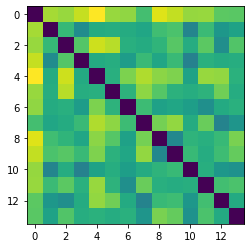

In [59]:
X_norm_sq = np.sum(emb**2, axis=1)
kernel = X_norm_sq[:, np.newaxis] + X_norm_sq[np.newaxis, :] - 2*np.dot(emb, emb.T)
kernel = np.sqrt(np.abs(kernel))
plt.imshow(kernel)

In [60]:
np.round(kernel, 1)

array([[0. , 0.5, 0.5, 0.6, 0.6, 0.5, 0.5, 0.4, 0.6, 0.6, 0.5, 0.5, 0.5,
        0.5],
       [0.5, 0. , 0.4, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.3, 0.4, 0.3,
        0.4],
       [0.5, 0.4, 0. , 0.5, 0.6, 0.6, 0.4, 0.4, 0.4, 0.5, 0.4, 0.5, 0.3,
        0.5],
       [0.6, 0.3, 0.5, 0. , 0.4, 0.4, 0.3, 0.4, 0.4, 0.4, 0.3, 0.4, 0.4,
        0.4],
       [0.6, 0.4, 0.6, 0.4, 0. , 0.4, 0.5, 0.6, 0.5, 0.5, 0.4, 0.5, 0.5,
        0.4],
       [0.5, 0.4, 0.6, 0.4, 0.4, 0. , 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.5,
        0.4],
       [0.5, 0.4, 0.4, 0.3, 0.5, 0.4, 0. , 0.4, 0.4, 0.4, 0.4, 0.3, 0.4,
        0.4],
       [0.4, 0.4, 0.4, 0.4, 0.6, 0.5, 0.4, 0. , 0.5, 0.5, 0.4, 0.5, 0.3,
        0.3],
       [0.6, 0.4, 0.4, 0.4, 0.5, 0.5, 0.4, 0.5, 0. , 0.3, 0.4, 0.4, 0.4,
        0.5],
       [0.6, 0.5, 0.5, 0.4, 0.5, 0.4, 0.4, 0.5, 0.3, 0. , 0.4, 0.4, 0.4,
        0.5],
       [0.5, 0.3, 0.4, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0. , 0.4, 0.3,
        0.3],
       [0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.3, 

In [12]:
def get_embedding(image):
    img = tf.image.resize(image, [256, 256])
    img = preprocess_input(tf.expand_dims(img, axis=0))
    emb = base_model.predict(img)
    return emb/np.linalg.norm(emb, axis=1)

In [13]:
emb_base = get_embedding(image)

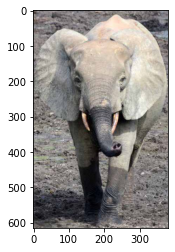

In [14]:
plt.imshow(image.numpy())

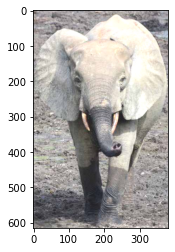

In [15]:
new_image = tf.image.random_brightness(image, 0.2)
plt.imshow(new_image.numpy().astype(np.uint8))
# new_emb = get_embedding(new_image)
# np.linalg.norm(new_emb-new_emb2)

In [16]:
new_image = tf.image.random_contrast(new_image2, 0.5, 2.0)
plt.imshow(new_image.numpy().astype(np.uint8))
# new_emb = get_embedding(new_image)
# np.linalg.norm(new_emb-new_emb2)

NameError: name 'new_image2' is not defined

In [ ]:
new_image = tf.image.random_saturation(new_image2, 0.75, 1.25)
plt.imshow(new_image.numpy().astype(np.uint8))
new_emb = get_embedding(new_image)
np.linalg.norm(new_emb-new_emb2)

In [ ]:
new_image = tf.image.random_hue(image, 0.1)
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].imshow(image.numpy().astype(np.uint8))
axes[1].imshow(new_image.numpy().astype(np.uint8))
axes[0].axis('off')
axes[1].axis('off')
new_emb = get_embedding(new_image)
np.linalg.norm(new_emb-emb_base)

In [ ]:
new_image2 = tf.image.resize_with_pad(image, target_height=256, target_width=256, )
plt.imshow(new_image2.numpy().astype(np.uint8))
new_emb2 = get_embedding(new_image2)
np.linalg.norm(new_emb2-emb_base)

In [ ]:
plt.imshow(new_image2.numpy().astype(np.uint8))

In [ ]:
new_image = tf.image.random_jpeg_quality(image , 20, 100)
plt.figure(figsize=(8,8))
plt.imshow(new_image.numpy().astype(np.uint8))
new_emb = get_embedding(new_image)
np.linalg.norm(new_emb-emb_base)